# Analysis of the dataset

In [14]:
from rasterio.plot import show
import rasterio
import numpy as np
import PIL.Image as Image
import cv2 


In [20]:
# Fonction pour lire les fichiers raster avec rasterio
def read_rasterio(file_path):
    with rasterio.open(file_path) as src:
        return src.read()
    
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''
    out = np.zeros_like(im)
    # faire l'equalization par channel
    def equalize(im_channel):
        v_min, v_max = np.percentile(im_channel,percentiles),np.percentile(im_channel, 100 - percentiles)

        # Clip the image to the percentile values
        im_clipped = np.clip(im_channel, v_min, v_max)

        # Scale the image to the 0-255 range
        im_scaled = np.round((im_clipped - v_min)*255 / (v_max - v_min))
        return im_scaled.astype(np.uint8)
    
    for channel in range(im.shape[2]):
        out[:,:,channel] = equalize(im[:,:,channel])
    
    return out

In [25]:
def preprocess_s2(img_array, size = (1000, 1000), percentiles=10):
    rgb_channel = img_array[0:3, :,:]
    rgb_channel = np.moveaxis(rgb_channel, 0, -1)
    rgb_channel = cv2.resize(rgb_channel, size)
    scaled_image = simple_equalization_8bit(rgb_channel, percentiles)
    return scaled_image

def preprocess_s1(img_array, size = (1000, 1000), percentiles=10):
    channel_1 = img_array[0,:,:]
    channel_1 = channel_1[np.newaxis, :, : ]
    channel_1 = np.moveaxis(channel_1, 0, -1)
    channel_1 = cv2.resize(channel_1, size)
    return channel_1    

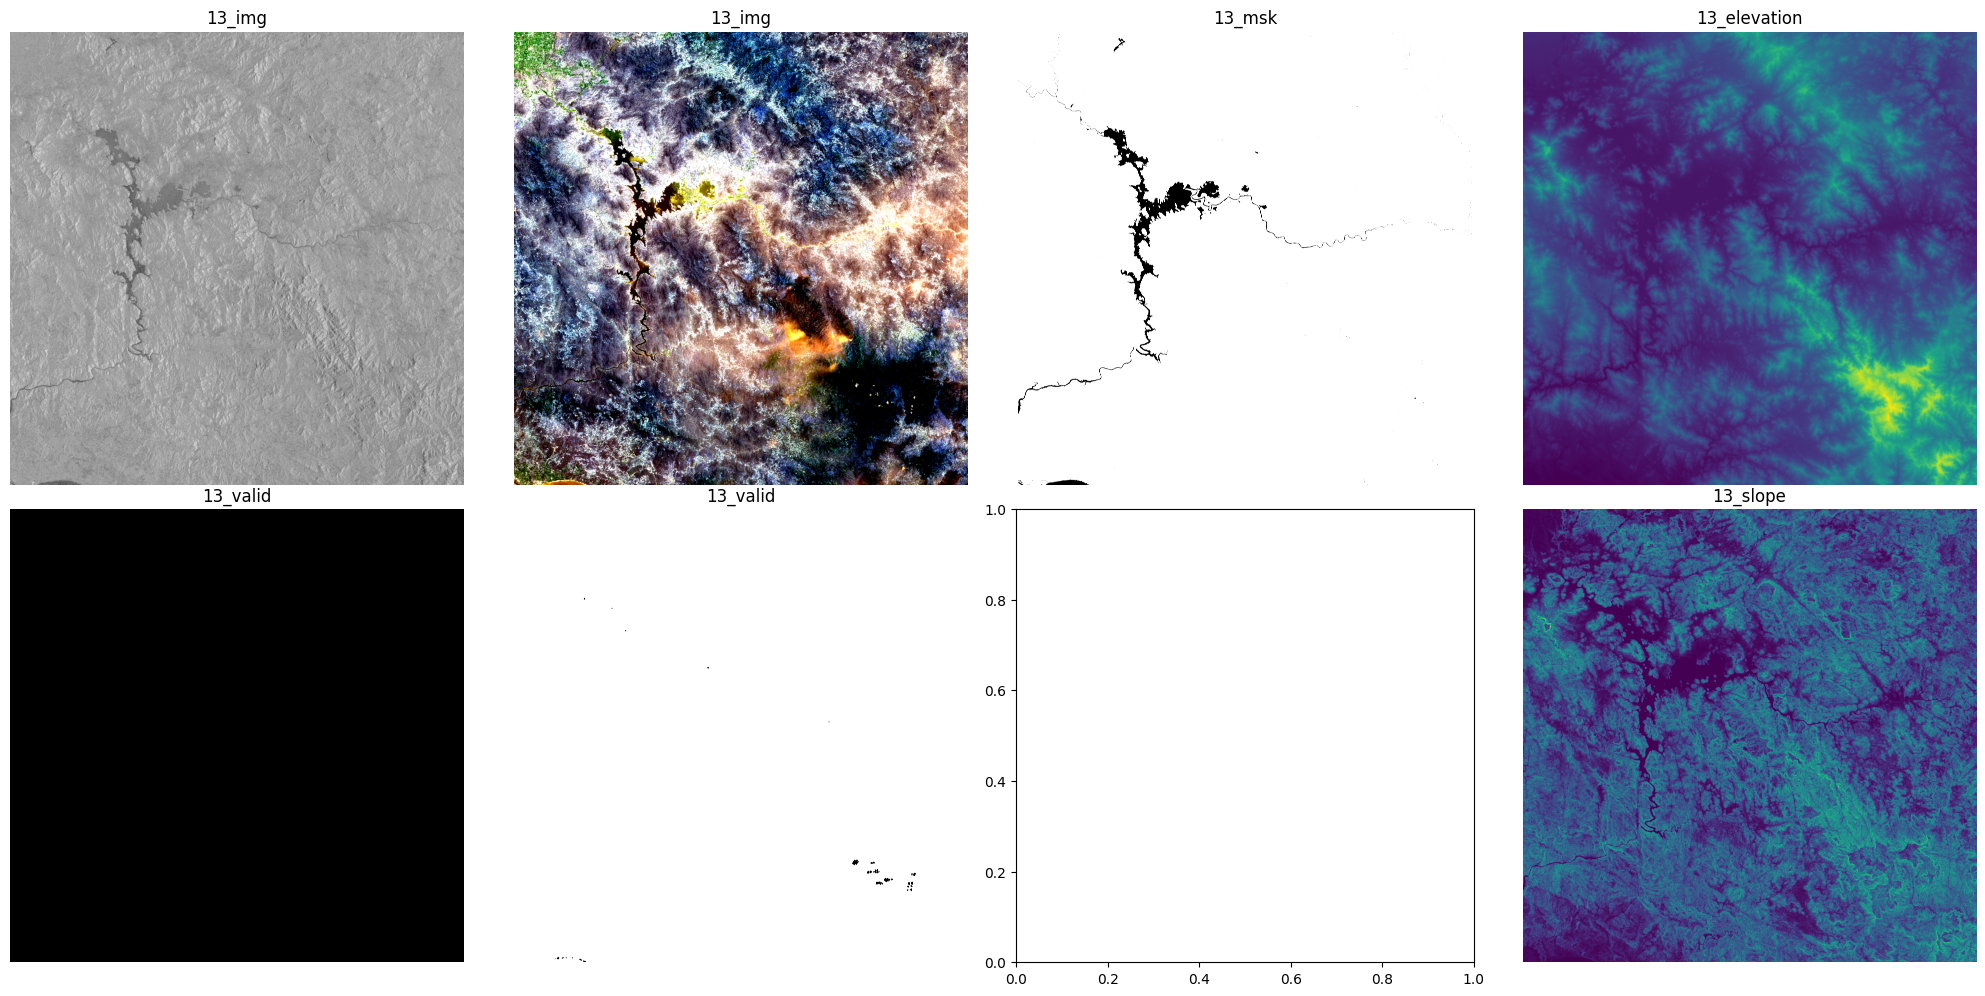

In [31]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np


def create_plot(sat_dir):
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))  # 2 lignes, 4 colonnes
    
    # Prépare les chemins vers les images en filtrant la liste des fichiers
    sort_list = os.listdir(sat_dir)
    s1_list = sorted([x for x in sort_list if "s1" in x and 'img' in x])
    s2_list = sorted([x for x in sort_list if "s2" in x and 'img' in x])
    mask_list = sorted([x for x in sort_list if "msk" in x])
    valid_list = sorted([x for x in sort_list if "valid" in x])
    elevation_list = sorted([x for x in sort_list if "elevation" in x])
    slope_list = sorted([x for x in sort_list if "slope" in x])

    # Affiche les images Sentinel-1 et Sentinel-2
    for i, img_path in enumerate(s1_list + s2_list):
        img = read_rasterio(os.path.join(sat_dir, img_path))
        type_img = "_".join(img_path.split("_")[2:]).split(".")[0]
        if 's2' in img_path:
            img = preprocess_s2(img)
        elif 's1' in img_path:
            img = preprocess_s1(img)
        ax[i//4][i%4].imshow(img, cmap='gray')
        ax[i//4][i%4].set_title(type_img)
        ax[i//4][i%4].axis('off')

    # Affiche les masques et les images de validation
    for i, img_path in enumerate(mask_list + valid_list):
        img = read_rasterio(os.path.join(sat_dir, img_path))
        img = img.squeeze()  # Assure-toi que la dimension inutile est supprimée
        type_img = "_".join(img_path.split("_")[2:]).split(".")[0]
        cmap = 'binary' if 'msk' in img_path else 'gray'
        # Calcule la bonne position de subplot
        row = (i + len(s1_list + s2_list)) // 4
        col = (i + len(s1_list + s2_list)) % 4
        ax[row][col].imshow(img, cmap=cmap)
        ax[row][col].set_title(type_img)
        ax[row][col].axis('off')

    # Place les images d'élévation et de pente dans la 4ème colonne
    for i, img_path in enumerate(elevation_list + slope_list):
        img = read_rasterio(os.path.join(sat_dir, img_path))
        img = img.squeeze()  # Supprime l'axe singleton pour l'affichage
        type_img = "_".join(img_path.split("_")[2:]).split(".")[0]
        row = i  # 'elevation' va en (0,3) et 'slope' va en (1,3)
        col = 3
        ax[row][col].imshow(img, cmap='viridis')
        ax[row][col].set_title(type_img)
        ax[row][col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the directory path
create_plot('part1/13')

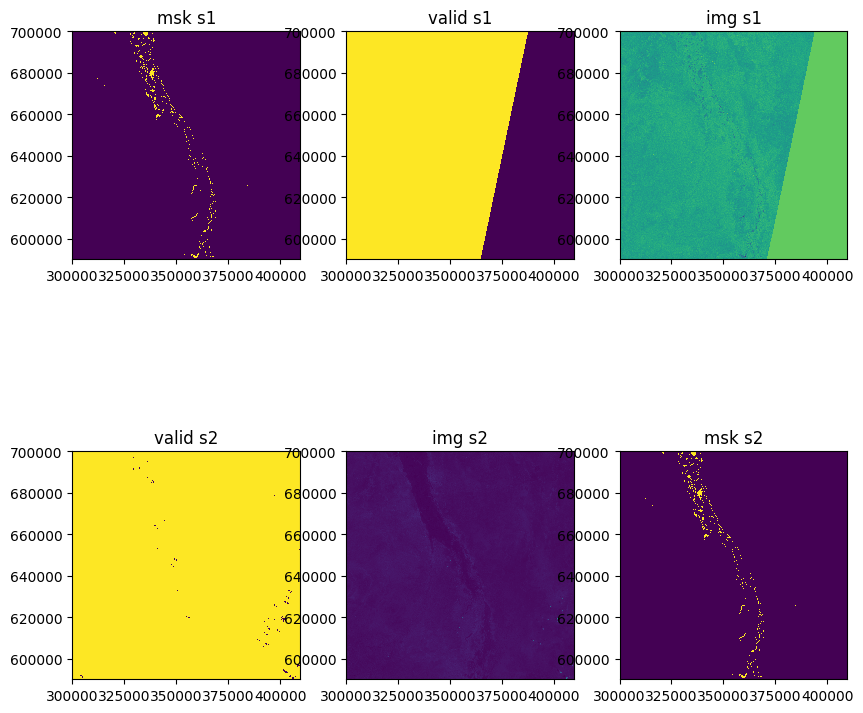

In [ ]:
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import os 

import rasterio
from rasterio.plot import show

sat_dir = "part1/5"
fig,ax = plt.subplots(2,3,figsize=(10,10))
i=0

sort_list = os.listdir(sat_dir)
s1_list = [x for x in sort_list if "s1" in x]
s2_list = [x for x in sort_list if "s2" in x]

for path in s1_list + s2_list:
    type_img = path.split("_")[-1].split(".")[0] + " " + path.split("_")[1]
    img =rasterio.open(os.path.join(sat_dir, path))
    cmap='viridis'

    show((img, 1), cmap = cmap , interpolation='none', ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(type_img)
    i+=1

In [ ]:
type(img)

rasterio.io.DatasetReader